In [1]:
import bempp.api
from bempp.api.assembly.blocked_operator import BlockedOperator
import math
import numpy as np
import scipy 
import cmath
from numba import objmode
from numpy.linalg import slogdet
from bempp.api.operators.far_field import helmholtz as helmholtz_farfield
import matplotlib.pyplot as plt
bempp.core.opencl_kernels.set_default_device(0,0)

In [2]:
h = 0.05
deg = 5

In [3]:
def normalized_spherical_harmonics(p, q, x):
    """Spherical Harmonic function of degree q"""
    azimuth = np.arctan2(x[1],x[0])
    polar = np.arccos(x[2]/np.linalg.norm(x))
    if p >= 0:
        return ((-1)**p) * scipy.special.sph_harm(p,q,azimuth,polar)
    else:
        return scipy.special.sph_harm(-p,q,azimuth,polar)*np.exp(1j*2*p*azimuth)

def spherical_bessel_function(q,x):
    """Spherical Bessel function of degree q"""
    r = np.linalg.norm(x)
    return np.sqrt(np.pi/(2*wavenumber*r))*scipy.special.jv(q+0.5, wavenumber*r)

def regular_spherical_wavefunctions(p,q,x):
    """Regular Spherical Wavefunction"""
    return spherical_bessel_function(q,x)*normalized_spherical_harmonics(p,q,x)

In [4]:
center1 = (0.15, 0, 0)
center2 = (-0.15, 0, 0)

cube1 = bempp.api.shapes.sphere(r = 0.1, h=h, origin=center1)
cube2 = bempp.api.shapes.sphere(r = 0.1, h=h, origin=center2)
combined_scatters = bempp.api.grid.grid.union([cube1,cube2])

unit_sphere = bempp.api.shapes.sphere(r = 1, origin=(0,0,0), h = h)
vert_unit_sphere = unit_sphere.vertices
space_unit_sphere = bempp.api.function_space(unit_sphere, 'P', 1)

space_cube1 = bempp.api.function_space(cube1, "P", 1)
space_cube2 = bempp.api.function_space(cube2, "P", 1)
space_combined = bempp.api.function_space(combined_scatters,'P',1)

In [5]:
list_lhs = []
for wavenumber in np.linspace(0.1,50,400):

    slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space_cube1, space_cube1, space_cube1, wavenumber)
    slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space_cube2 , space_cube1, space_cube1, wavenumber)
    slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space_cube1, space_cube2 , space_cube2 , wavenumber)
    slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space_cube2 , space_cube2 , space_cube2 , wavenumber)

    mat11 = slp11.weak_form().A
    mat12 = slp12.weak_form().A
    mat21 = slp21.weak_form().A
    mat22 = slp22.weak_form().A
    mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
    mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

    mat = np.block([[mat11,mat12],[mat21,mat22]])  
    mat2 = np.block([[mat11,mat12_zero],[mat21_zero,mat22]])

    list_lhs.append(-np.imag(np.log(np.linalg.det(mat @ np.linalg.inv(mat2))))/np.pi)

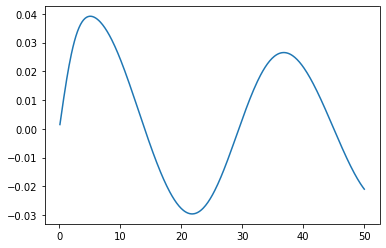

In [6]:
plt.plot(np.linspace(0.1,50,400), list_lhs)

In [5]:
mass_mat = bempp.api.operators.boundary.sparse.identity(space_unit_sphere, space_unit_sphere, space_unit_sphere).weak_form().A

In [6]:
sph_harm_coeff = []

for q in range(deg+1):
    for p in range(-q,q+1):
        @bempp.api.complex_callable
        def sph_harm(x,n,domain_index,result):
            with objmode():
                result[0] = normalized_spherical_harmonics(p,q,x)
        sph_harm_grid = bempp.api.GridFunction(space_unit_sphere, fun = sph_harm)
        sph_harm_coeff.append(np.conj(sph_harm_grid.coefficients)/((-1j)**(q+1)))

In [ ]:
_list = []
for index, wavenumber in enumerate(np.linspace(0.1,50,400)[322:]):
    eta = wavenumber

    identity1 = bempp.api.operators.boundary.sparse.identity(space_cube1, space_cube1, space_cube1)
    slp1 = bempp.api.operators.boundary.helmholtz.single_layer(space_cube1, space_cube1, space_cube1, wavenumber)
    dlp1 = bempp.api.operators.boundary.helmholtz.double_layer(space_cube1, space_cube1, space_cube1, wavenumber)
    slp_far1 = helmholtz_farfield.single_layer(space_cube1, vert_unit_sphere, wavenumber)
    dlp_far1 = helmholtz_farfield.double_layer(space_cube1, vert_unit_sphere, wavenumber)

    lhs1 = 0.5 * identity1 + dlp1 - 1j* eta *slp1

    identity2 = bempp.api.operators.boundary.sparse.identity(space_cube2, space_cube2, space_cube2)
    slp2 = bempp.api.operators.boundary.helmholtz.single_layer(space_cube2, space_cube2, space_cube2, wavenumber)
    dlp2 = bempp.api.operators.boundary.helmholtz.double_layer(space_cube2, space_cube2, space_cube2, wavenumber)
    slp_far2 = helmholtz_farfield.single_layer(space_cube2, vert_unit_sphere, wavenumber)
    dlp_far2 = helmholtz_farfield.double_layer(space_cube2, vert_unit_sphere, wavenumber)

    lhs2 = 0.5 * identity2 + dlp2 - 1j* eta *slp2

    identity = bempp.api.operators.boundary.sparse.identity(space_combined, space_combined, space_combined)
    slp = bempp.api.operators.boundary.helmholtz.single_layer(space_combined, space_combined, space_combined, wavenumber)
    dlp = bempp.api.operators.boundary.helmholtz.double_layer(space_combined, space_combined, space_combined, wavenumber)
    slp_far = helmholtz_farfield.single_layer(space_combined, vert_unit_sphere, wavenumber)
    dlp_far = helmholtz_farfield.double_layer(space_combined, vert_unit_sphere, wavenumber)

    lhs = 0.5 * identity + dlp - 1j* eta *slp
    #===================================================================================================================
    slp_far_field_coeff1 = []
    slp_far_field_coeff2 = []
    slp_far_field_coeff = []

    for q in range(deg+1):
        for p in range(-q,q+1):
            @bempp.api.complex_callable
            def dirichlet_fun(x,n,domain_index,result):
                    with objmode():
                        result[0] = - regular_spherical_wavefunctions(p,q,x)

            rhs_fun1 = bempp.api.GridFunction(space_cube1, fun = dirichlet_fun)
            field1, info1 = bempp.api.linalg.gmres(lhs1, rhs_fun1, tol=1E-8)
            slp_far_field_coeff1.append(dlp_far1.evaluate(field1) - 1j * eta * slp_far1.evaluate(field1))

            rhs_fun2 = bempp.api.GridFunction(space_cube2, fun = dirichlet_fun)
            field2, info2 = bempp.api.linalg.gmres(lhs2, rhs_fun2, tol=1E-8)
            slp_far_field_coeff2.append(dlp_far2.evaluate(field2) - 1j * eta * slp_far2.evaluate(field2))

            rhs_fun = bempp.api.GridFunction(space_combined, fun = dirichlet_fun)
            field, info = bempp.api.linalg.gmres(lhs, rhs_fun, tol=1E-8)
            slp_far_field_coeff.append(dlp_far.evaluate(field) - 1j * eta * slp_far.evaluate(field))
    #====================================================================================================
    T_matrix1 = np.zeros(((deg+1)**2,(deg+1)**2),dtype = complex)
    for i in range((deg+1)**2):
        for j in range((deg+1)**2):
            T_matrix1[i,j] = (slp_far_field_coeff1[j] @ mass_mat @ sph_harm_coeff[i])*wavenumber

    T_matrix2 = np.zeros(((deg+1)**2,(deg+1)**2),dtype = complex)
    for i in range((deg+1)**2):
        for j in range((deg+1)**2):
            T_matrix2[i,j] = (slp_far_field_coeff2[j] @ mass_mat @ sph_harm_coeff[i])*wavenumber

    T_matrix = np.zeros(((deg+1)**2,(deg+1)**2),dtype = complex)
    for i in range((deg+1)**2):
        for j in range((deg+1)**2):
            T_matrix[i,j] = (slp_far_field_coeff[j] @ mass_mat @ sph_harm_coeff[i])*wavenumber

    S_matrix = np.identity(T_matrix.shape[0]) + 2*T_matrix
    S_matrix1 = np.identity(T_matrix1.shape[0]) + 2*T_matrix1
    S_matrix2 = np.identity(T_matrix2.shape[0]) + 2*T_matrix2

    #rhs_value_S =  (np.log(np.linalg.det(S_matrix))-(np.log(np.linalg.det(S_matrix1)) + np.log(np.linalg.det(S_matrix2))))/(2*np.pi*1j)
    rhs_value_S =  np.log(np.linalg.det(S_matrix)/(np.linalg.det(S_matrix1)*np.linalg.det(S_matrix2)))/(2*np.pi*1j)
    _list.append(np.real(rhs_value_S))
    print(index, wavenumber,rhs_value_S)

In [7]:
List1 = [0.0014991026743278585, 0.003369033455629753, 0.0052277284366945564, 0.007069085401665269, 0.008887182464061321, 
         0.010676337080171218, 0.012431159974684147, 0.014146603470655736, 0.015818003026993356, 0.017441111690445682,
         0.019012126843979585, 0.0205277094078643, 0.021984995258377694, 0.02338159924823598, 0.024715612184765926,
         0.025985591220651267, 0.027190544736331767, 0.02832991136033929, 0.029403535298921337, 0.030411637704824225, 
         0.03135478551617015, 0.03223385768104241, 0.033050010933444285, 0.033804644258230716, 0.03449936365077262, 
         0.03513594737649619, 0.03571631226363358, 0.03624248143844068, 0.036716553840782575, 0.037140675790260695, 
         0.037517014806855986, 0.03784773583357851, 0.03813497994950348, 0.03838084561616621, 0.03858737245225594, 
         0.038756527504583055, 0.03889019393536606, 0.03899016202732488, 0.03905812237394592, 0.039095661148373956,
         0.03910425725183975, 0.039085281210631054, 0.03903999563251241, 0.03896955708349778, 0.038875019053576515, 
         0.03875733617239838, 0.03861736928505148, 0.03845589078467789, 0.03827359100789988, 0.038071085079820925,
         0.037848919560691606, 0.03760757952621078, 0.037347495660339645, 0.037069051194047645, 0.036772588735048614, 
         0.03645841584538801, 0.03612681505752812, 0.035778043697510746, 0.03541234386780336, 0.035029945732780954, 
         0.03463107256566451, 0.03421594441619916, 0.03378478186679365, 0.03333780896075775, 0.0328752559608042,
         0.032397361648732165, 0.03190437382216989, 0.03139655248730881, 0.03087416875652379, 0.030337508965282537, 
         0.029786870636797504, 0.029222565103041595, 0.028644916694091613, 0.028054262635922034, 0.027450950672837045,
         0.026835344393810565, 0.02620781445040795, 0.025568742538116484, 0.024918519432851442, 0.02425754492464856, 
         0.02358622339303914, 0.02290496828751969, 0.0222141980625725, 0.02151433537600096, 0.020805806813802178, 
         0.020089042327616914, 0.019364473921423497, 0.018632536170879312, 0.017893664267277468, 0.017148294736266476, 
         0.016396863715365424, 0.01563980729949402, 0.014877561041225678, 0.014110560495406753, 0.013339239213908064,
         0.01256402980380323, 0.011785362851033898, 0.01100366716064009, 0.010219370341969685, 0.00943289642900019]

List2 = [0.008644667814219556, 0.007855104584062099, 0.007064623378204417, 0.006273638076862069, 0.005482561218123067,
         0.004691799256294196, 0.0039017569620006963, 0.003112835046089018, 0.0023254310245433138, 0.00153993898597997, 
         0.0007567485237781638, -2.3754691106870916e-05, -0.0008011892285268352, -0.0015751769874154103, -0.0023453456013114056, 
         -0.003111326360866586, -0.0038727551038605116, -0.004629272748362344, -0.005380522289579257, -0.006126154479239189, 
         -0.006865822047766118, -0.007599183716116798, -0.008325902217576071, -0.009045644122778779, -0.009758080324868839, 
         -0.010462886967107711, -0.011159743053961767, -0.011848331302817126, -0.012528338963913246, -0.013199456677523464, 
         -0.013861378530433652, -0.01451380065206969, -0.015156424832207877, -0.01578895369621361, -0.016411092764737734, 
         -0.017022550978563224, -0.01762303951742792, -0.018212271627840775, -0.01878996298714595, -0.01935583087761716, 
         -0.01990959474383875, -0.02045097537481067, -0.020979695304522396, -0.021495478818428018, -0.021998050745523728,
         -0.02248713747335945, -0.022962465708382875, -0.023423764475081682, -0.023870760772830835, -0.02430318479387809, 
         -0.024720765658787003, -0.025123233014796003, -0.025510316695448048, -0.025881745767618505, -0.026237249473218614,
         -0.0265765557397345, -0.026899393427224493, -0.027205488288305695, -0.027494566107996644, -0.027766350206350758, 
         -0.02802056250112725, -0.02825692259480221, -0.028475148063533184, -0.028674953382043473, -0.028856050616200193, 
         -0.029018147866069554, -0.02916095035751503, -0.029284158676059685, -0.029387469702978525, -0.02947057483860001, 
         -0.02953316172391702, -0.029574913169115324, -0.029595504930176538, -0.029594607594364452, -0.029571887006722246, 
         -0.029527002131301838, -0.029459605036117924, -0.029369341570243884, -0.02925585142631033, -0.029118766995514973,
         -0.028957713592678926, -0.028772310472657055, -0.028562169579703846, -0.028326894093843567, -0.028066083437264827, 
         -0.02777932773409637, -0.0274662111334848, -0.027126311798139183, -0.026759200172126275, -0.02636444136293109, 
         -0.025941594349518208, -0.025490212871539873, -0.025009845753156415, -0.024500035819034097, -0.023960322373188174, 
         -0.023390240079766172, -0.022789320271544757, -0.022157091101472723, -0.021493078399993475, -0.02079680555971769]

List3 = [-0.02006779445068846, -0.01930556653452681, -0.018509642078603245, -0.017679541622225653, -0.016814786789169305, 
         -0.01591490061713782, -0.014979406317383882, -0.01400783162031359, -0.012999706636166435, -0.01195456446022357, 
         -0.01087194278830748, -0.009751383667022837, -0.008592434836731656, -0.007394649428457939, -0.006157585904526814, 
         -0.004880810184352895, -0.003563895402693692, -0.0022064214760720738, -0.0008079760339009519, 0.0006318448919043287, 
         0.002113438174662383, 0.0036371901732500144, 0.005203481157728671, 0.006812680953913842, 0.008465150777709382, 
         0.01016124248486631, 0.011901300158602222, 0.013685658164750519, 0.015514642269326272, 0.017388569386703894, 
         0.01930774832356355, 0.02127247965119346, 0.023283055709762863, 0.025339761876031368, 0.02744287721063997,
         0.029592672649256815, 0.03178941552409075, 0.03403336699155479, 0.036324783914986385, 0.03866392028465588, 
         0.041051027337016946, 0.04348635501096057, 0.04597015260348466, 0.04850267202646851, 0.05108416664638068, 
         0.05371489526140419, 0.05639512261032691, 0.059125120901994364, 0.061905172540141024, 0.06473557260453702, 
         0.06761663061219085, 0.07054867331333185, 0.07353204991278198, 0.0765671343809667, 0.07965432923813422, 
         0.08279406826920896, 0.08598682449181576, 0.08923311254258275, 0.09253349616476494, 0.09588859284502639, 
         0.099299084361943, 0.1027657216692904, 0.10628933447133755, 0.10987084363646371, 0.11351126817588296, 
         0.11721173826069234, 0.12097351042959188, 0.1247979844441794, 0.12868671521878752, 0.13264143801168948, 
         0.13666408264765012, 0.14075680376839328, 0.1449220031878183, 0.14916236154288204, 0.1534808690607283, 
         0.15788086314672617, 0.16236607181277296, 0.16694065835420413, 0.17160927496057873, 0.1763771217798459, 
         0.1812500106069655, 0.18623444170210343, 0.1913376852566735, 0.1965678780243296, 0.20193412988999987,
         0.20744664258414158, 0.21311685112183668, 0.2189575758673466, 0.22498320040281466, 0.23120987360764186, 
         0.23765574015367144, 0.24434120129749778, 0.2512892174301375, 0.2585256543990063, 0.266079674499931, 
         0.2739841968609751, 0.2822764179557825, 0.29099841351201344, 0.30019783197317607, 0.3099286902229082]


List4 = [0.32025228312619836, 0.33123822190681396, 0.34296560782530006, 0.3555243455660825, 0.3690165793479219, 
         0.38355822961518304, 0.3992805458928472, 0.41633155409607586, 0.434877178636405, 0.4551016532467092, 
         0.47720667604753203, -0.4985915322036457, -0.47206840448337584, -0.4430018335049549, -0.4111890590176223, 
         -0.3764705659344071, -0.33876038652879875, -0.29807928801430117, -0.2545833027059502, -0.2085766235694432,
         -0.16049802635883947, -0.1108764908031282, -0.060263609307785945, -0.00916158731507947, 0.0420315576515007, 
         0.09304572144581649, 0.14373031209887333, 0.19402283432309692, 0.243907182568355, 0.2933725821326735, 
         0.34238033459551726, 0.39084193415761487, 0.4386096253499901, 0.4854787380230272, 0.53119988, 
         0.57549793, 0.61809426, 0.65872826, 0.69717519, 0.73325827, 
         0.76685434, 0.79789369, 0.82635541, 0.85225974, 0.87565914, 
         0.8966292 , 0.91526018, 0.93164972, 0.94589684, 0.95809732, 
         0.96834011, 0.97670493, 0.98326066, 0.98806448, 0.99116175, 
         0.99258644, 0.99236232, 0.99050478, 0.98702361, 0.98192666, 
         0.97522466, 0.96693713, 0.9570993 , 0.94576968, 0.93303749, 
         0.91902895, 0.90391098, 0.88789095, 0.87121145, 0.85414002, 
         0.83695475, 0.81992786, 0.80330988, 0.78731689, 0.77212234, 
         0.75785394, 0.74459513, 0.73238973, 0.72124854, 0.71115651, 
         0.7020797 , 0.69397133, 0.68677679, 0.68043757, 0.67489414, 
         0.67008806, 0.66596329, 0.66246714, 0.65955069, 0.65716905, 
         0.65528136, 0.65385072, 0.65284401, 0.65223167, 0.65198752, 
         0.65208847, 0.65251432, 0.65324755, 0.65427316, 0.65557842]

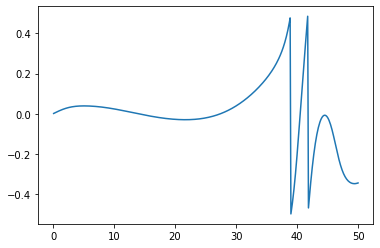

In [12]:
plt.plot(np.linspace(0.1,50, 400)[0:], List1 + List2 + List3 + List4)

In [14]:
np.array([-0.46880012252888215, 
         -0.4245020678801372, -0.38190574017432255, -0.3412717440250432, -0.30282481222385405, -0.2667417316189239,
         -0.23314566342719756, -0.20210630692985096, -0.173644589935887, -0.14774026213590813, -0.12434085741221458, 
         -0.10337079588554614, -0.0847398190386915, -0.06835028484040975, -0.05410315594738611, -0.041902680722446455,
         -0.031659890027241365, -0.02329506820880943, -0.01673934339134052, -0.011935520955486986, -0.008838252218250676, 
         -0.007413557415861046, -0.007637682188881003, -0.009495221149989684, -0.012976394764019876, -0.01807334491674416, 
         -0.024775343988757803, -0.033062872918305765, -0.042900697402218475, -0.05423031567786981, -0.06696250675492084, 
         -0.0809710464313725, -0.09608901769116038, -0.11210905409893017, -0.1287885533417731, -0.14585998018146526, 
         -0.163045250639855, -0.18007214379529282, -0.19669012026820168, -0.2126831085768536, -0.22787766476140292, 
         -0.24214606147513862, -0.25540487148469954, -0.26761026989778613, -0.27875146449930893, -0.28884348958291783, 
         -0.297920296638428, -0.30602866855512273, -0.3132232086518965, -0.31956243235650666, -0.3251058566676534, 
         -0.32991194228146165, -0.3340367073566043, -0.3375328583589582, -0.34044930640711785, -0.3428309478594197, 
         -0.3447186377865733, -0.346149278991087, -0.34715599290179633, -0.34776832517005635, -0.3480124764026257, 
         -0.34791153087342075, -0.3474856841561285, -0.34675244693680374, -0.3457268428255032, -0.34442157506084764]) + 1

array([0.53119988, 0.57549793, 0.61809426, 0.65872826, 0.69717519,
       0.73325827, 0.76685434, 0.79789369, 0.82635541, 0.85225974,
       0.87565914, 0.8966292 , 0.91526018, 0.93164972, 0.94589684,
       0.95809732, 0.96834011, 0.97670493, 0.98326066, 0.98806448,
       0.99116175, 0.99258644, 0.99236232, 0.99050478, 0.98702361,
       0.98192666, 0.97522466, 0.96693713, 0.9570993 , 0.94576968,
       0.93303749, 0.91902895, 0.90391098, 0.88789095, 0.87121145,
       0.85414002, 0.83695475, 0.81992786, 0.80330988, 0.78731689,
       0.77212234, 0.75785394, 0.74459513, 0.73238973, 0.72124854,
       0.71115651, 0.7020797 , 0.69397133, 0.68677679, 0.68043757,
       0.67489414, 0.67008806, 0.66596329, 0.66246714, 0.65955069,
       0.65716905, 0.65528136, 0.65385072, 0.65284401, 0.65223167,
       0.65198752, 0.65208847, 0.65251432, 0.65324755, 0.65427316,
       0.65557842])

In [ ]:
List4 = [0.32025228312619836, 0.33123822190681396, 0.34296560782530006, 0.3555243455660825, 0.3690165793479219, 
         0.38355822961518304, 0.3992805458928472, 0.41633155409607586, 0.434877178636405, 0.4551016532467092, 
         0.47720667604753203, -0.4985915322036457, -0.47206840448337584, -0.4430018335049549, -0.4111890590176223, 
         -0.3764705659344071, -0.33876038652879875, -0.29807928801430117, -0.2545833027059502, -0.2085766235694432,
         -0.16049802635883947, -0.1108764908031282, -0.060263609307785945, -0.00916158731507947, 0.0420315576515007, 
         0.09304572144581649, 0.14373031209887333, 0.19402283432309692, 0.243907182568355, 0.2933725821326735, 
         0.34238033459551726, 0.39084193415761487, 0.4386096253499901, 0.4854787380230272, -0.46880012252888215, 
         -0.4245020678801372, -0.38190574017432255, -0.3412717440250432, -0.30282481222385405, -0.2667417316189239,
         -0.23314566342719756, -0.20210630692985096, -0.173644589935887, -0.14774026213590813, -0.12434085741221458, 
         -0.10337079588554614, -0.0847398190386915, -0.06835028484040975, -0.05410315594738611, -0.041902680722446455,
         -0.031659890027241365, -0.02329506820880943, -0.01673934339134052, -0.011935520955486986, -0.008838252218250676, 
         -0.007413557415861046, -0.007637682188881003, -0.009495221149989684, -0.012976394764019876, -0.01807334491674416, 
         -0.024775343988757803, -0.033062872918305765, -0.042900697402218475, -0.05423031567786981, -0.06696250675492084, 
         -0.0809710464313725, -0.09608901769116038, -0.11210905409893017, -0.1287885533417731, -0.14585998018146526, 
         -0.163045250639855, -0.18007214379529282, -0.19669012026820168, -0.2126831085768536, -0.22787766476140292, 
         -0.24214606147513862, -0.25540487148469954, -0.26761026989778613, -0.27875146449930893, -0.28884348958291783, 
         -0.297920296638428, -0.30602866855512273, -0.3132232086518965, -0.31956243235650666, -0.3251058566676534, 
         -0.32991194228146165, -0.3340367073566043, -0.3375328583589582, -0.34044930640711785, -0.3428309478594197, 
         -0.3447186377865733, -0.346149278991087, -0.34715599290179633, -0.34776832517005635, -0.3480124764026257, 
         -0.34791153087342075, -0.3474856841561285, -0.34675244693680374, -0.3457268428255032, -0.34442157506084764]

In [18]:
for i in range(200):
    print(np.linspace(0.1,50, 400)[i],list_lhs[i], (List1+List2+List3+List4)[i])

0.1 0.0014997970846770436 0.0014991026743278585
0.22506265664160402 0.0033705927032965546 0.003369033455629753
0.35012531328320806 0.005230150248824464 0.0052277284366945564
0.47518796992481205 0.0070723658235677155 0.007069085401665269
0.600250626566416 0.008891316099021647 0.008887182464061321
0.72531328320802 0.010681317211916192 0.010676337080171218
0.8503759398496241 0.012436978807693354 0.012431159974684147
0.9754385964912281 0.014153252256491614 0.014146603470655736
1.1005012531328322 0.015825472254664116 0.015818003026993356
1.2255639097744362 0.017449391230344193 0.017441111690445682
1.3506265664160402 0.0190212061850656 0.019012126843979585
1.4756892230576442 0.02053757781566175 0.0205277094078643
1.6007518796992484 0.02199564196318742 0.021984995258377694
1.7258145363408524 0.023393013621220125 0.02338159924823598
1.8508771929824563 0.02472778389899276 0.024715612184765926
1.9759398496240603 0.025998510471427407 0.025985591220651267
2.1010025062656643 0.027204202156069016 0.

In [14]:
1/((21.735 - 5.102)*2)

0.03006072265977274